In [237]:
import torch
import torch.nn as nn
import torch.cuda as cuda
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import pdb
import pickle 
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset
from os import listdir
from os.path import isfile, join

import torch.nn.functional as F
from sklearn.decomposition import PCA

import random 
import pandas as pd 
import scipy.io as sio
import csv
import os

from torch.nn.utils import weight_norm, spectral_norm

In [238]:
numSubjects = 17
nE = 127
dataDir = "/home/zeinab.schaefer/DMfiles/"
npyDataDir = "/home/zeinab.schaefer/codes/dataDM/"
newDataDir = "/home/zeinab.schaefer/codes/dataPCA/"

In [4]:
# generate the name of the files 
# the form is FARAH_sub0XY_LS(1/4)_tr(1:4)
# 16 subjects with LS1 and LS4, subject 17 has only LS1
# LS1:Loud speaker to the left 
# LS4:Loud speaker to the right 
fns = []
labels = []
for subject in range(1,numSubjects+1):
    for spk in [1,4]:
        for trial in [1,2]: #range(1,4+1):
            dt = []
            fn = 'FARAH_'+'sub0%0.2d'%subject+'_LS'+str(spk)+'_'+str(trial)
            fns.append(fn)

# Concatenate all data subjects , the dimension is nE x T'

In [22]:
train_samples = []
valid_samples = []
# To initialize
all_samples = np.zeros((nE, 0))

first_matrix = []

for subject in fns:
    dtfile = npyDataDir + subject + ".npy"
    tempData = np.load(dtfile)
    transpose_tempData = np.transpose(tempData)
    
    assert np.shape(transpose_tempData)[0] == nE, "dimension does not read"
    
    all_samples = np.concatenate((all_samples, transpose_tempData), axis = 1)
    transpose_tempData = []
    # TODO: Remove the first column 

In [23]:
np.save('all_samples.npy', all_samples)

In [24]:
all_samples = np.load('all_samples.npy') # load
print(np.shape(all_samples))
n_samples = np.shape(all_samples)[1]

(127, 8355840)


In [25]:
X = all_samples
X = X.T 

# Apply PCA 

In [26]:
nc = 6
pca = PCA(n_components=nc, whiten=True)
# input X : array-like, shape (n_samples, n_features)
# output : X_new : array-like, shape (n_samples, n_components)
print('shape of X:' , np.shape(X))
pca.fit(X)

shape of X: (8355840, 127)


PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

In [ ]:
def apply_PCA(opt, nc, X_c):
    if opt == 1:
        pca = PCA(n_components=nc, whiten=True)
        # input X : array-like, shape (n_samples, n_features)
        # output : X_new : array-like, shape (n_samples, n_components)
        print('shape of X:' , np.shape(X_c))
        pca.fit(X_c)
       
        return pca.components_ 
    else:
        # Eigenvalue, eigenvector decomposition
        # getting the corresponding eogenvalues 
        cov_matrix = np.dot(X_c.T, X_c) / (n_samples - 1)
        print('shape of cov matrix', np.shape(cov_matrix))

        evals, evecs = np.linalg.eig(cov_matrix)
        idx = np.argsort(evals)[::-1]
        evecs = evecs[:,idx]

        print('eigen vectors', np.shape(evecs))
        evals = evals[idx]
        print('eigen values', np.shape(evals))
        
        pc_components = evecs[:,0:nc]
        print('size of principal components', np.shape(pc_components))
        return pc_components  

# Mapping the electrodes onto pc_components

In [27]:
for subject in fns:
    dtfile = npyDataDir + subject + ".npy"
    X = np.load(dtfile)
    # project the data onto the main components
    mapped_data = pca.transform(X).T
    newDtFile = newDataDir + subject + ".npy"
    np.save(newDtFile, mapped_data)

In [17]:
newDataDir


'/home/erl.local/zeinab.schaefer/codes/dataPCA/'

# Defining Useful Modules 

# Constructing the validation and training data loader 

In [28]:
#from dplf import *

In [335]:
class DirectionalMicrophoneDataset(Dataset):
    def __init__(self,path,samples):
        # path: the path to the npy files 
        # subjects: the list of the subjects to be loaded    
        self.path = path 
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, indx):
        itempath = self.path + self.samples[indx]['fname'] +'.npy'
        signal = np.load(itempath).T # loads the data 
        #signal = signal[::5,:]
        signal_label = self.samples[indx]['label'] # the corresponding label 
        return {'signal': signal, 'label': signal_label}

class RandomWindow(object):
    def __init__(self, window_size):
        self.window_size = window_size
        
    def __call__(self, sample):
        signal, label = sample['signal'], sample['label']
        
        # generate a random interval 
        random_index = np.random.randint(signal.shape[0] - self.window_size)
        dt = signal[random_index:random_index+self.window_size,:]
        return {'signal': dt, 'label': label}
    
    
class ToTensor(object):
    def __call__(self, sample):
        signal, label = sample['signal'], sample['label']
        dt = torch.from_numpy(signal.transpose())
        return {'signal': dt, 'label': label}
    
    
class TransformedDataset(Dataset):
    def __init__(self, dataset, *transforms):
        self.dataset = dataset
        self.transforms = transforms
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        sample = self.dataset[idx]
        for transform in self.transforms:
            sample = transform(sample)
        return sample


def sample_for(subject, spk, trial, label):
    fname = 'FARAH_'+'sub0%0.2d'%subject+'_LS'+str(spk)+'_'+str(trial)
    return {'fname': fname, 'label': label }

def create_subj_samples():
    val_id = random.randint(1, 18)
    train_samples = []
    valid_samples = []
    for subject in range(1,18):
        for spk in [1, 4]:
            if spk == 1:
                label = 0 # Right    
            else:
                label = 1 # Left
            if subject == val_id:
                for trial in range(1,3):
                    valid_samples.append(sample_for(subject,spk,trial,label))
                #all_trials = range(1, 3) # range(1,5)
                #train_trials = random.sample(all_trials, 1)
                #valid_trials = np.setdiff1d(all_trials, train_trials)
                # list of validation names accordingly
                #for trial in valid_trials:
                #    valid_samples.append(sample_for(subject, spk, trial, label))
                #for trial in train_trials:
                #    train_samples.append(sample_for(subject, spk, trial, label))
            else:
                for trial in range(1,3):
                    train_samples.append(sample_for(subject, spk, trial, label))
    return (train_samples, valid_samples)

def create_dt_samples():
    train_samples = []
    valid_samples = []
    for subject in range(1,18):           
        for spk in [1, 4]:
            
            if spk == 1:
                label = 0 # Right    
            else:
                label = 1 # Left
            # randomly take three trials out of four for training
            # one trial for testing
            all_trials = range(1, 3) # range(1,5)
            train_trials = random.sample(all_trials, 1)
            valid_trials = np.setdiff1d(all_trials, train_trials)
        
            
            # list of validation names accordingly
            for trial in valid_trials:
                valid_samples.append(sample_for(subject, spk, trial, label))
            
            for trial in train_trials:
                train_samples.append(sample_for(subject, spk, trial, label))
    return (train_samples, valid_samples)

def all_samples():
    samples = []
    for subject in range(1,18):
        for spk in [1,4]:
            if spk == 1:
                label = 0
            else:
                label = 1
            for trial in [1,2]: #range(1,5):
                samples.append(sample_for(subject, spk, trial, label))
    return samples

def random_split(samples, train_percent = 80):
    random.shuffle(samples)
    train_limit = (len(samples) * train_percent) // 100
    return samples[:train_limit], samples[train_limit:]

In [336]:
train_samples, valid_samples = create_dt_samples()

In [337]:
#train_samples, valid_samples = random_split(all_samples())

In [338]:
train_samples, valid_samples = create_subj_samples()

In [339]:
dmd = DirectionalMicrophoneDataset(newDataDir, train_samples)

In [340]:
bs = 128
window = RandomWindow(2048)
to_tensor = ToTensor()
dataset_train = TransformedDataset(dmd, window, to_tensor)
train_dl = DataLoader(dataset_train, batch_size=bs, shuffle=True)

In [341]:
dataset_train[3]['signal'].shape

torch.Size([6, 2048])

In [342]:
dmd_valid = DirectionalMicrophoneDataset(newDataDir, valid_samples)
valid_dataset = TransformedDataset(dmd_valid, window, to_tensor)
valid_dl = DataLoader(valid_dataset, batch_size=bs)

In [308]:
valid_dataset[3]['signal'].shape

torch.Size([6, 2048])

# Network Structure

In [343]:
def c1d(ni:int, no:int, ks:int=1, stride:int=1, padding:int=0):
    "Create and initialize a `nn.Conv1d` layer with spectral normalization."
    conv = nn.Conv1d(ni, no, ks, stride=stride, padding=padding, bias=False)
    nn.init.kaiming_normal_(conv.weight)
    return weight_norm(conv)
    #return spectral_norm(conv)


def conv1d(in_channels, out_channels, kernel_size, stride=1):
    return nn.Sequential(
        c1d(in_channels, out_channels, kernel_size, stride, kernel_size//2),
        #nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, bias = False, padding=kernel_size//2),
        nn.BatchNorm1d(out_channels, momentum = 0.01),
        nn.ReLU(inplace=True)
        #nn.LeakyReLU(negative_slope = 0.1, inplace=True)
    )

def preact_conv1d(in_channels, out_channels, kernel_size=1, groups=1):
    return nn.Sequential(
        nn.BatchNorm1d(in_channels),
        nn.Conv1d(in_channels=in_channels,
                  out_channels=out_channels,
                  kernel_size=kernel_size,
                  padding=(kernel_size-1)//2,
                  groups=groups),
        nn.LeakyReLU(negative_slope=0.1, inplace=True),
    )


class ResBlock(nn.Module):
    def __init__(self, nc, kernel_size=9):
        super().__init__()
        self.conv1 = conv1d(nc, nc//2, kernel_size=kernel_size)
        #self.conv2 = preact_conv1d(nc//2, nc//2, kernel_size= 3, groups=nc//8)
        self.conv3 = conv1d(nc//2, nc, kernel_size=kernel_size)
    
    def forward(self, x):
        y = self.conv1(x)
        #y = self.conv2(y)
        y = self.conv3(y)
        return x + F.dropout(y, training=self.training)

def res_blocks(nf, n_blocks=2):
        blocks = [ResBlock(nf) for i in range(n_blocks)]
        return nn.Sequential(*blocks)

class DMNetwork(nn.Module):    
    def __init__(self):
        super().__init__()
        self.convs = nn.Sequential( # 512
            conv1d(nc, 64, kernel_size=9, stride=4), # 256
            res_blocks(64, 1),
            conv1d(64, 128, kernel_size=9, stride=4), # 128
            nn.Dropout(0.5),
            res_blocks(128, 3),
            conv1d(128, 256, kernel_size=9, stride=4), # 64
            nn.Dropout(0.5),
            res_blocks(256, 5),
            conv1d(256, 512, kernel_size=9, stride=4), # 32
            nn.Dropout(0.5)
        )        
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(self.convs(x))
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [344]:
# the proposed network from the paper (see page 40)
class ProposedNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.convs = nn.Sequential(
            conv1d(in_channels = nc, out_channels= 96, kernel_size=32),
            conv1d(in_channels = 96, out_channels= 36, kernel_size=16),
            conv1d(in_channels = 36, out_channels= 48, kernel_size=16),
            conv1d(in_channels = 48, out_channels= 16, kernel_size=8)
        )
        
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(16, 2)
        
    def forward(self, x):
        x = self.convs(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        #x = self.fc1(F.dropout(x, training = self.training))
        return x

class MyProposedNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.convs = nn.Sequential(#512
            conv1d(in_channels = nc, out_channels= 32, kernel_size=9, stride=4),#256
            conv1d(in_channels = 32, out_channels= 64, kernel_size=9, stride=4),#128
            conv1d(in_channels = 64, out_channels= 128, kernel_size=9, stride=4),#64
            conv1d(in_channels = 128, out_channels= 256, kernel_size=9, stride=4),#32
        )
        
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(256, 2)
        
    def forward(self, x):
        x = self.convs(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(F.dropout(x, training = self.training))
        #x = self.fc1(F.dropout(x, training = self.training))
        return x

In [248]:
class DN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv1d(in_channels=nc, out_channels=32, kernel_size= 9, bias=False)
        
        self.res1 = ResBlock(32)
        self.res2 = ResBlock(32)
        #self.relu1 = nn.LeakyReLU()
        self.pool1 = nn.AdaptiveAvgPool1d(8)
        self.fc1 = nn.Linear(32*8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.pool1(x)
        
        x = x.view(x.size(0), -1)
        
        # fully connected layer 1
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x

In [249]:
    
class SimpleNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.convs = nn.Sequential(
            conv1d(nc, 64, kernel_size=32, pool_size=4),
            conv1d(64, 32, kernel_size=16),
            conv1d(32, 16, kernel_size=8)
        )
        
        self.pool = nn.AdaptiveAvgPool1d(8)
        #self.lrelu = nn.LeakyReLU(negative_slope=0.001, inplace=True)
        self.fc1 = nn.Linear(16*8, 100)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        x = self.pool(self.convs(x))
        #x = self.lrelu(x)
        x = x.view(x.size(0), -1)
        
        # Fully connected layer 1
        x = self.fc1(x)
        x = F.relu(x)
        
        #x = F.dropout(x, training=True) 
        x = nn.dropout(p=0.2)
        # Fully connected layer 2
        x = self.fc2(x)
        
        return x

IndentationError: expected an indented block (<ipython-input-249-848720a1e0b2>, line 3)

In [345]:
nc = 6

In [346]:
# The model
#net = DMNetwork()
net = ProposedNet()
if cuda.is_available():
    print("cuda available")
    net = net.cuda()
else:
    net = net.cpu()

# Our loss function
criterion = nn.CrossEntropyLoss()

# Our optimizer
learning_rate = 0.0005
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) 

cuda available


# Training 

In [ ]:
num_epochs = 2000

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []

for epoch in range(num_epochs):
    ############################
    # Train
    ############################    
    iter_loss = 0.0
    correct = 0
    iterations = 0
    episodes = 128
    
    net.train()                   # Put the network into training mode
    for idx in range(episodes):
        for samples in train_dl:
            # Convert torch tensor to Variable
            items = Variable(samples['signal'])
            classes = Variable(samples['label'])
            #pdb.set_trace()
            # If we have GPU, shift the data to GPU
            if cuda.is_available():
                items = items.cuda()
                classes = classes.cuda()
            else:
                items = items.cpu()
                classes = classes.cpu()
            
            optimizer.zero_grad()     # Clear off the gradients from any past operation
            outputs = net(items.float())      # Do the forward pass
            loss = criterion(outputs, classes) # Calculate the loss
            #pdb.set_trace()
            #iter_loss += loss.data[0] # Accumulate the loss
            iter_loss += loss.data.item()
            loss.backward()           # Calculate the gradients with help of back propagation
            optimizer.step()          # Ask the optimizer to adjust the parameters based on the gradients
            
            # Record the correct predictions for training data 
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == classes.data).sum()
            iterations += 1
    
    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    #train_accuracy.append((100 * correct / len(mnist_train_loader.dataset)))
    #print("Tr Error: %.2f" % (iter_loss/iterations)+ "---- Accuracy: %.2f%%" % (100/episodes * correct.item() / len(train_dl.dataset)))
    print('Train Error: %.4f,----Acc: %.4f' %((iter_loss/iterations), (100/episodes * correct.item() / len(train_dl.dataset))))
    
    # computing the validation loss 
    loss = 0.0
    correct = 0
    iterations = 0
    
    # putting the network into evaluation mode 
    net.eval()
    val_episodes = 64
    for idx in range(val_episodes):
        for validSample in valid_dl:
            
            items = Variable(validSample['signal'])
            classes = Variable(validSample['label'])
            
            # If we have GPU, shift the data to GPU
            if cuda.is_available():
                items = items.cuda()
                classes = classes.cuda()
            else:
                items = items.cpu()
                classes = classes.cpu()
            
            outputs = net(items.float())
            loss += criterion(outputs, classes).data.item()
            #loss += criterion(outputs, classes).data[0]
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == classes.data).sum()
            iterations  +=1 
            
            
    valid_loss.append(loss/iterations)
    # Record the validation accuracy
    #pdb.set_trace()
    valid_accuracy.append(correct.item() / len(valid_dl.dataset) * 100.0 / val_episodes)
    #pdb.set_trace()
    print ('Val Error: %.4f,----Acc: %.4f' %(valid_loss[-1], valid_accuracy[-1]))

Train Error: 0.6876,----Acc: 55.5176
Val Error: 0.7215,----Acc: 45.7031
Train Error: 0.6660,----Acc: 59.2529
Val Error: 0.7280,----Acc: 46.8750
Train Error: 0.6485,----Acc: 61.6821
Val Error: 0.8291,----Acc: 38.2812
Train Error: 0.6392,----Acc: 62.9395
Val Error: 0.8157,----Acc: 41.4062
Train Error: 0.6376,----Acc: 62.5366
Val Error: 0.8488,----Acc: 37.1094
Train Error: 0.6286,----Acc: 64.7095
Val Error: 0.8777,----Acc: 33.2031
Train Error: 0.6108,----Acc: 66.0034
Val Error: 0.9018,----Acc: 43.3594
Train Error: 0.6005,----Acc: 66.6870
Val Error: 0.9233,----Acc: 35.9375
Train Error: 0.5835,----Acc: 68.7134
Val Error: 0.9766,----Acc: 37.5000
Train Error: 0.5780,----Acc: 69.2505
Val Error: 1.1309,----Acc: 47.6562
Train Error: 0.5608,----Acc: 70.4956
Val Error: 1.1343,----Acc: 53.1250
Train Error: 0.5420,----Acc: 72.3022
Val Error: 1.0219,----Acc: 53.9062
Train Error: 0.5339,----Acc: 72.9370
Val Error: 1.0793,----Acc: 42.9688
Train Error: 0.5128,----Acc: 74.3652
Val Error: 1.2566,----Acc: 

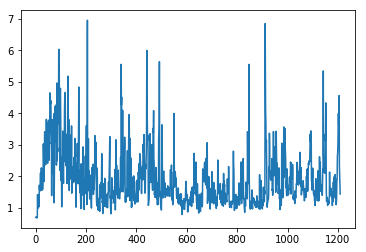

In [333]:
plt.plot(valid_loss)
plt.savefig('/home/erl.local/zeinab.schaefer/codes/valid_ex2.png')

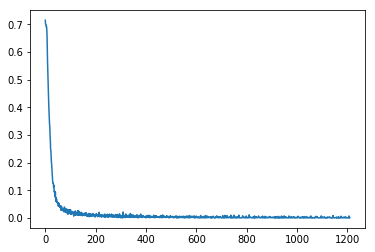

In [334]:
plt.plot(train_loss)
plt.savefig('/home/erl.local/zeinab.schaefer/codes/train_ex2.png')

In [53]:
train_dl.__iter__().__next__()['signal'].shape

torch.Size([54, 6, 256])

In [281]:
torch.save(net, "small-model")

/home/erl.local/zeinab.schaefer/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type MyProposedNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
